In [1]:
# Import required libraries
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import json
from pathlib import Path

# Import DetectionMetrics components
from detectionmetrics.datasets.coco import CocoDataset
from detectionmetrics.models.torch_detection import TorchImageDetectionModel
from detectionmetrics.utils import conversion as uc
from detectionmetrics.utils import io as uio

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
# Create directories for data
!mkdir -p local/data/models
!mkdir -p local/outputs

In [3]:
# Initialize COCO dataset
# Using existing COCO data paths
# img_dir = "/home/dpascualhe/datasets/coco/val2017"
# ann_file = "/home/dpascualhe/datasets/coco/annotations/instances_val2017.json"

img_dir = "/Users/sakprave/Downloads/Coco/images/val2017"
ann_file = "/Users/sakprave/Downloads/Coco/annotations/instances_val2017.json"


# Check if files exist
if not os.path.exists(img_dir) or not os.path.exists(ann_file):
    print("COCO data not found. Please check the paths above.")
else:
    # Load dataset
    dataset = CocoDataset(annotation_file=ann_file, image_dir=img_dir, split="train")
    print(f"Dataset loaded with {len(dataset.dataset)} samples")
    print(f"Number of classes: {len(dataset.ontology)}")

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
Dataset loaded with 5000 samples
Number of classes: 80


In [4]:
# Create a pre-trained detection model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
model.eval()

# Save the model
model_path = "local/data/models/maskrcnn_model.pt"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(model, model_path)
model_cfg = {
    "batch_size": 1,
    "num_workers": 0,
    "confidence_threshold": 0.8,
    "nms_threshold": 0.3
}
config_path = "local/data/models/maskrcnn_config.json"
with open(config_path, "w") as f:
    json.dump(model_cfg, f, indent=2)


ontology_path = "local/data/models/coco_model_ontology.json"
with open(ontology_path, "w") as f:
    json.dump(dataset.ontology, f, indent=2)

print("Model and configuration saved!")

Model and configuration saved!


In [5]:
detection_model = TorchImageDetectionModel(
    model=model_path,
    model_cfg=config_path,
    ontology_fname=ontology_path,  # This is the model ontology (indices as keys)
    device="cpu"
)


print("Detection model initialized!")

Model is not a TorchScript model. Loading as native PyTorch model.
Detection model initialized!


In [ ]:
# Function to visualize detection results
def visualize_detections(image, predictions, ground_truth=None, title="Detection Results"):
    """Visualize detection predictions and optionally ground truth."""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Display image
    ax.imshow(image)

    #map labels to class names
    label_to_name = {v['idx'] : k for k, v in dataset.ontology.items()}

    # Draw prediction boxes
    if predictions and isinstance(predictions, dict) and 'boxes' in predictions:
        boxes = predictions['boxes'].cpu().numpy()
        scores = predictions['scores'].cpu().numpy()
        labels = predictions['labels'].cpu().numpy()

        for i, (box, score, category_idx) in enumerate(zip(boxes, scores, labels)):
            # Convert [x1, y1, x2, y2] to [x, y, width, height]
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1

            # Get class name
            class_name = label_to_name.get(category_idx, str(category_idx))

            # Create rectangle patch
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2, edgecolor='red', facecolor='none', alpha=0.7
            )
            ax.add_patch(rect)

            # Add label
            ax.text(x1, y1-5, f'{class_name}: {score:.2f}',
                   color='red', fontsize=10, weight='bold')

    # Draw ground truth boxes (if provided)
    if ground_truth and isinstance(ground_truth, tuple) and len(ground_truth) >= 2:
        gt_boxes, gt_category_indices = ground_truth

        for _, (box, category_idx) in enumerate(zip(gt_boxes, gt_category_indices)):
            # Convert [x1, y1, x2, y2] to [x, y, width, height]
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1

            # Get class name
            class_name = label_to_name.get(category_idx, str(category_idx))

            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2, edgecolor='green', facecolor='none', alpha=0.7
            )
            ax.add_patch(rect)

            ax.text(x1, y1+height+5, f'GT: {class_name}',
                   color='green', fontsize=10, weight='bold')

    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

 Testing inference on: /Users/sakprave/Downloads/Coco/images/val2017/000000397133.jpg
 Found 12 detections
 Ground truth: 19 objects


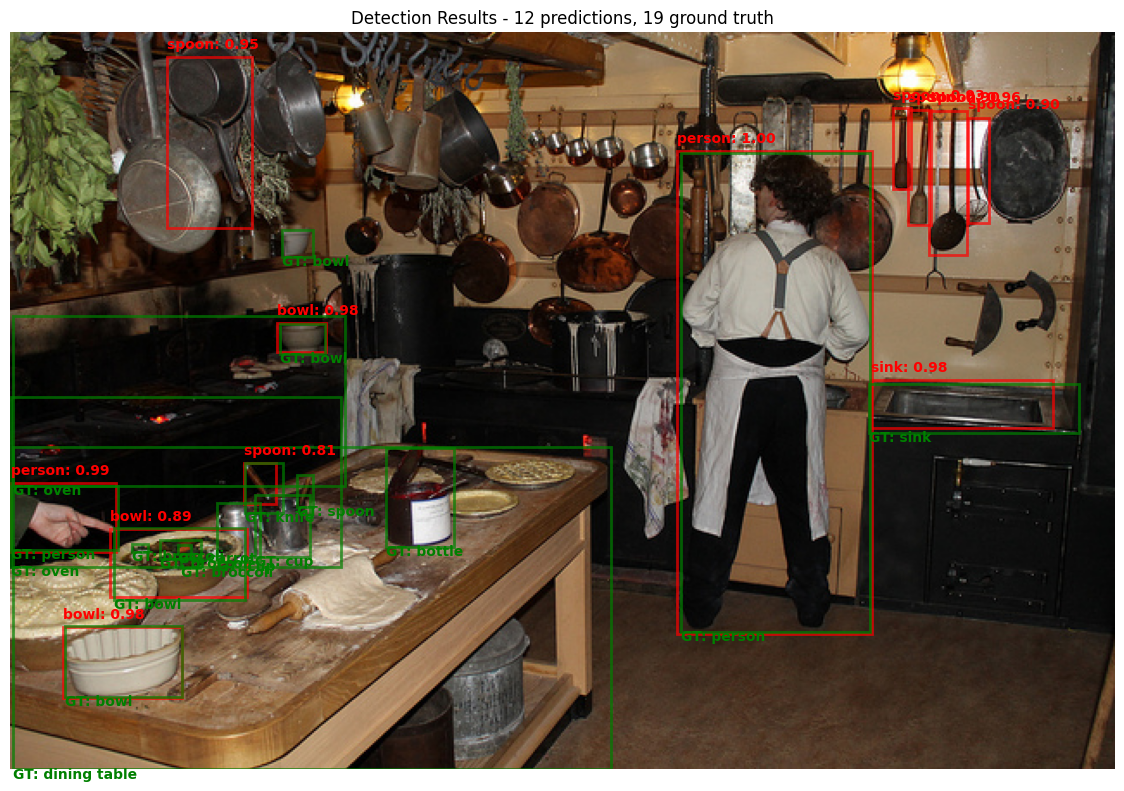

In [ ]:
# Test inference on a single image
if 'dataset' in locals() and len(dataset.dataset) > 0:
    # Make filenames global first
    dataset.make_fname_global()

    # Get first image from dataset
    sample_idx = 0
    image_path = dataset.dataset.iloc[sample_idx]['image']

    # Load and display original image
    image = Image.open(image_path).convert('RGB')
    print(f" Testing inference on: {image_path}")
    # Run inference
    predictions = detection_model.inference(image)

    print(f" Found {len(predictions['boxes'])} detections")
    # Get ground truth for comparison
    annotation_path = dataset.dataset.iloc[sample_idx]['annotation']
    ground_truth = dataset.read_annotation(annotation_path)

    print(f" Ground truth: {len(ground_truth[0])} objects")
    # Visualize results
    visualize_detections(
        np.array(image),
        predictions,
        ground_truth,
        title=f"Detection Results - {len(predictions['boxes'])} predictions, {len(ground_truth[0])} ground truth"
    )
else:
    print(" Dataset not loaded. Please check the data paths above.")

In [ ]:
# Run evaluation on a subset of the dataset
# For demonstration, we'll use a small subset
if 'dataset' in locals():

    # Create a small subset for faster evaluation
    small_dataset = dataset.dataset
    small_dataset = dataset.dataset.iloc[10:15]  # Selects rows with indices

    # Temporarily replace dataset with subset
    original_dataset = dataset.dataset
    dataset.dataset = small_dataset

    # dataset.dataset_dir = "/Users/sakprave/Downloads/Coco"

    # Make sure the output directory exists
    predictions_outdir = "local/outputs/detection_preds"
    os.makedirs(predictions_outdir, exist_ok=True)

    # # Path to ontology translation file
    # ontology_translation_path = "local/data/models/ontology_translation.json"

    try:
        # Run evaluation with ontology translation
        results = detection_model.eval(
            dataset=dataset,
            split="train",  # Use train split for demo
            # ontology_translation=ontology_translation_path,  # Add ontology translation
            predictions_outdir=predictions_outdir,
            results_per_sample=True
        )

        print(" Evaluation completed!")

    except Exception as e:
        print(f" Evaluation failed: {e}")
        import traceback
        traceback.print_exc()

    finally:
        # Restore original dataset
        dataset.dataset = original_dataset
        # Reset dataset_dir back to None (as it was after make_fname_global)
        dataset.dataset_dir = None
else:
    print("  Dataset not loaded. Please check the data paths above.")


  0%|          | 0/5 [00:00<?, ?it/s]

 Evaluation completed!



Metrics DataFrame:


,person,bicycle,car,motorcycle,airplane,bus,train,truck,boat,traffic light,...,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush,mean
AP,0.870130,0.0,0.272727,0.636364,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,0.106294,0.0,1.000000,NaN,NaN,NaN,NaN,0.357276
Precision,0.928571,0.0,0.500000,1.000000,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,0.294118,0.0,0.666667,NaN,NaN,NaN,NaN,0.466075
Recall,0.928571,0.0,0.250000,0.666667,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,0.217391,0.0,1.000000,NaN,NaN,NaN,NaN,0.359035
TP,13.000000,0.0,1.000000,2.000000,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,5.000000,0.0,2.000000,NaN,NaN,NaN,NaN,1.666667
FP,1.000000,0.0,1.000000,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,12.000000,1.0,1.000000,NaN,NaN,NaN,NaN,1.000000
FN,1.000000,1.0,3.000000,1.000000,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,18.000000,0.0,0.000000,NaN,NaN,NaN,NaN,2.055556
mAP@[0.5:0.95],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.261200
AUC-PR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.710032


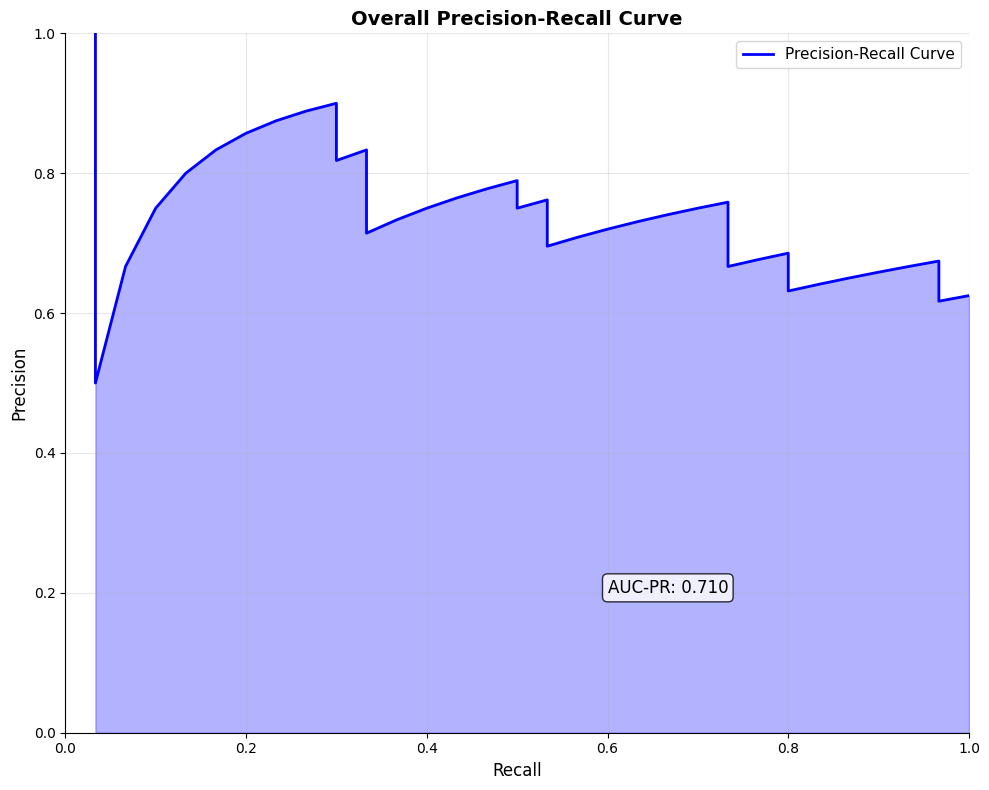

Precision-Recall Curve plotted with AUC-PR: 0.710


In [ ]:
# Visualize Precision-Recall Curve
import matplotlib.pyplot as plt
import numpy as np

# Check the structure of results
if isinstance(results, dict):
    metrics_df = results["metrics_df"]
    metrics_factory = results["metrics_factory"]
else:
    # Fallback for old format
    metrics_df = results
    metrics_factory = None

# Display the metrics DataFrame
print("\nMetrics DataFrame:")
display(metrics_df)

# Visualize Precision-Recall Curve if metrics factory is available
if metrics_factory is not None:
    # Get the precision-recall curve data
    curve_data = metrics_factory.get_overall_precision_recall_curve()
    auc_pr = metrics_factory.compute_auc_pr()

    # Create the plot
    plt.figure(figsize=(10, 8))

    # Plot the precision-recall curve
    plt.plot(curve_data['recall'], curve_data['precision'],
             linewidth=2, color='blue', label=f'Precision-Recall Curve')

    # Fill the area under the curve
    plt.fill_between(curve_data['recall'], curve_data['precision'],
                     alpha=0.3, color='blue')

    # Add AUC-PR annotation
    plt.text(0.6, 0.2, f'AUC-PR: {auc_pr:.3f}',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # Customize the plot
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Overall Precision-Recall Curve', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)

    # Set axis limits
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    # Add some styling
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

    print(f"Precision-Recall Curve plotted with AUC-PR: {auc_pr:.3f}")

else:
    print("Precision-recall curve data not available.")
    print("The evaluation results don't contain the metrics factory object.")

    # Alternative: Show the metrics DataFrame
    if hasattr(metrics_df, 'index') and 'AP' in metrics_df.index:
        print("\nAvailable metrics:")
        for metric in metrics_df.index:
            if metric in ['AP', 'mAP@[0.5:0.95]', 'AUC-PR']:
                mean_value = metrics_df.loc[metric, 'mean']
                print(f"{metric}: {mean_value:.3f}")